In [1]:
import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
from preprocess_data import EigenfacesDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

In [2]:
INPUT_SIZE = 120 * 128
NUM_EPOCHS = 10
BATCH_SIZE = 10
LEARNING_RATE = 1e-3

In [3]:
normalize_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])
eigenfaces_dataset = EigenfacesDataset(
    data_dir='../data',
    label='head_position',
    transform=normalize_transform)
trainset, testset = random_split(
    eigenfaces_dataset, [BATCH_SIZE * 10, len(eigenfaces_dataset) - BATCH_SIZE * 10])

In [4]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE)

In [5]:
def train(net, train_loader, test_loader,
          num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE,
          compute_accs=False):
    """
    This function trains the given network on the training data for the given number of epochs.
    If compute_accs is true, evaluates the train and test accuracy of the network at the end of
    each epoch.

    Args:
        net: The neural network to train
        train_loader, test_loader: The pytorch dataset loaders for the trainst and testset
        num_epochs: The number of times to loop over the batches in train_loader
        learning_rate: The learning rate for the optimizer
        compute_accs: A bool flag for whether or not this function should compute the train and test
                      accuracies at the end of each epoch. This feature is useful for visualizing
                      how the model is learning, but slows down training time.
    Returns:
        The train and test accuracies if compute_accs is True, None otherwise
    """
    # First initialize the criterion (loss function) and the optimizer
    # (algorithm like gradient descent). Here we use a common loss function for multi-class
    # classification called the Cross Entropy Loss and the popular Adam algorithm.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_accs = []
    test_accs = []

    for epoch in range(1, num_epochs + 1):
        batch_num = 1
        for images, labels in train_loader:   # Loop over each batch in train_loader

            # If you are using a GPU, speed up computation by moving values to the GPU
            if torch.cuda.is_available():
                net = net.cuda()
                images = images.cuda()
                labels = labels.cuda()
                
            optimizer.zero_grad()               # Reset gradient for next computation
            outputs = net(images)               # Forward pass: compute the output class given a image
            loss = criterion(outputs, labels)   # Compute loss: difference between the pred and true 
            loss.backward()                     # Backward pass: compute the weight
            optimizer.step()                    # Optimizer: update the weights of hidden nodes

            if batch_num % BATCH_SIZE == 0:                           
                print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_num}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
            
            batch_num += 1

        if compute_accs:
            train_acc = accuracy(net, train_loader)
            test_acc = accuracy(net, test_loader)

            print(f'Epoch [{epoch}/{num_epochs}], ',
                  f'Train Accuracy {100 * train_acc:.2f}%, ',
                  f'Test Accuracy {100 * test_acc:.2f}%')
            
            train_accs.append(train_acc)
            test_accs.append(test_acc)

    if compute_accs:
        return train_accs, test_accs
    else:
        return None


def accuracy(net, data_loader):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification
    accuracy.

    Args:
        net: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    for images, labels in data_loader:
        if  torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count

    return correct / total


def plot_history(histories):
    """
    Given a series of training/test accuracies from training, plots them to visualize learning.

    Args:
        histories: A list of dictionaries storing information about each model trained.
                   Each dictionary should have the keys:
                        * name: The model name
                        * train_accs: A list of train accuracies
                        * test_accs: A list of test accuracies.
    """
    plt.figure(figsize=(16,10))
    epochs = list(range(1, len(histories[0]['train_accs']) + 1))
    for model_history in histories:
      val = plt.plot(epochs, model_history['test_accs'],
                     '--', label='Test')
      plt.plot(epochs, model_history['train_accs'], color=val[0].get_color(),
               label='Train')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])

In [6]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.linear = nn.Linear(INPUT_SIZE, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

Epoch [1/10], Step [10/10], Loss: 1.1439
Epoch [1/10],  Train Accuracy 63.00%,  Test Accuracy 52.86%
Epoch [2/10], Step [10/10], Loss: 1.5153
Epoch [2/10],  Train Accuracy 68.00%,  Test Accuracy 60.31%
Epoch [3/10], Step [10/10], Loss: 0.6845
Epoch [3/10],  Train Accuracy 86.00%,  Test Accuracy 73.47%
Epoch [4/10], Step [10/10], Loss: 0.1795
Epoch [4/10],  Train Accuracy 88.00%,  Test Accuracy 72.33%
Epoch [5/10], Step [10/10], Loss: 0.2133
Epoch [5/10],  Train Accuracy 97.00%,  Test Accuracy 78.82%
Epoch [6/10], Step [10/10], Loss: 0.3291
Epoch [6/10],  Train Accuracy 99.00%,  Test Accuracy 82.06%
Epoch [7/10], Step [10/10], Loss: 0.0503
Epoch [7/10],  Train Accuracy 99.00%,  Test Accuracy 83.97%
Epoch [8/10], Step [10/10], Loss: 0.0394
Epoch [8/10],  Train Accuracy 100.00%,  Test Accuracy 81.68%
Epoch [9/10], Step [10/10], Loss: 0.0616
Epoch [9/10],  Train Accuracy 100.00%,  Test Accuracy 84.73%
Epoch [10/10], Step [10/10], Loss: 0.0121
Epoch [10/10],  Train Accuracy 100.00%,  Test A

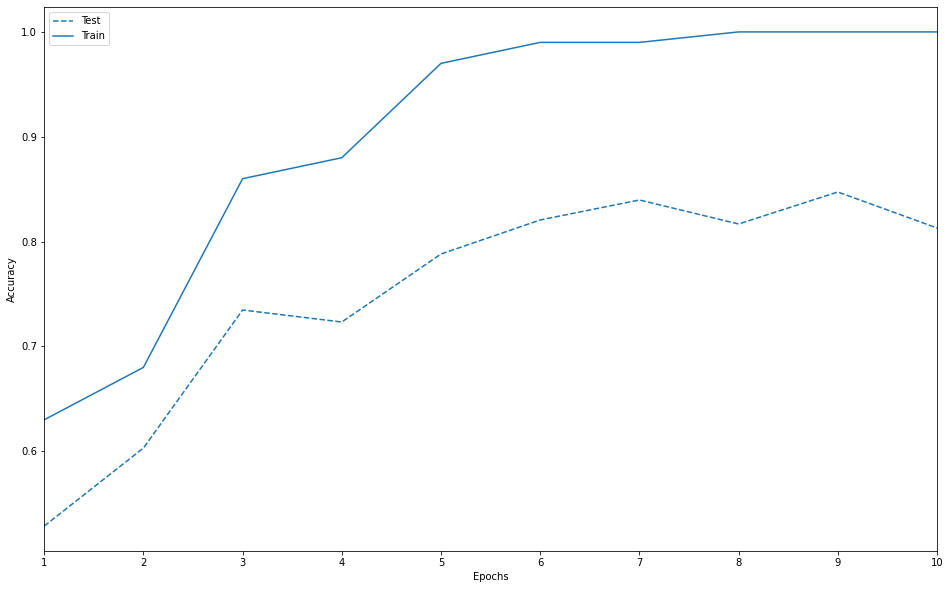

In [7]:
%%time 
histories = []
net = Net(eigenfaces_dataset.num_classes)
train_history, test_history = train(net, train_loader, test_loader, 
                                    num_epochs=NUM_EPOCHS, 
                                    learning_rate=LEARNING_RATE, 
                                    compute_accs=True)
histories.append({
    'train_accs': train_history, 
    'test_accs': test_history
})
plot_history(histories)